In [1]:
import numpy as np
import ast
import matplotlib.pyplot as plt
import os

In [2]:
path = '/global/homes/e/ecastori/PostBorn/output/Cell_dd/'

In [3]:
#cosmology
h         = 0.6770
omega_cdm = 0.11923
omega_b   = 0.02247
Omega_b   = omega_b/h**2
Omega_cdm = omega_cdm/h**2
Omega_m   = Omega_b+Omega_cdm
ns        = 0.96824
A0        = 2.10732*10**(-9)

#dictionary for class
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
print(cosmo_dict)


c      = 299792458/1000. #km/s

#prefactor for Cl_kk computation from Cl_dd
prefac = 1.5*Omega_m*(100.)**2/c**2 #without h

{'h': 0.677, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'A_s': 2.10732e-09, 'n_s': 0.96824, 'k_pivot': 0.05}


In [4]:
#get comoving distance from integrating c/H_0/E(z)
def integrand(z):
    return c/(100.)*(Omega_m*(1.+z)**3+(1.-Omega_m))**(-0.5)#Mpc/h

def chi(z):
    z_ = np.arange(0.,z,0.0001)
    res = np.trapz(integrand(z_),z_)
    return res

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


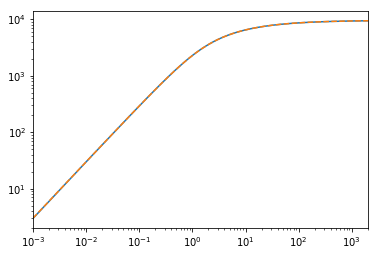

In [5]:
#get z_cmb and comving distance from class

from classy import Class
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
cosmo_b               = cosmo.get_background()

class_z               = cosmo_b['z'][::-1]
class_chi             = cosmo_b['comov. dist.'][::-1]

derivParams           = cosmo.get_current_derived_parameters(['z_rec'])
z_cmb                 = derivParams['z_rec']


from scipy.interpolate import InterpolatedUnivariateSpline as ius
chi_z = ius(class_z,class_chi*h)#Mpc/h

#check if interpolation works
z_=np.logspace(-3,3.5)
plt.figure()
plt.loglog(class_z,class_chi*h)
plt.loglog(z_,chi_z(z_),ls='--')
plt.xlim(0,2000)
plt.show()

In [6]:
#read in ells and header of one file, compare chis in header with computed ones
fname= 'C_ell_z1_1.000_z2_0.06097_lmin2_lmax2000_nd0.dat'
data = np.loadtxt(path+fname,skiprows=1)
ell  = data[:,0]

with open(path+fname) as f:
    a= f.readline().split(',')
    f.close()
print(a)
print('chi(z1) Class', chi_z(2.200))
print('my chi(z1)', chi(2.200))
print('chi(z2), CLASS',chi_z(2.305))

#set chi_cmb
chi_cmb = chi(z_cmb)*h
print('Distance to CMB:',chi_cmb)

[' C_ell(z1', 'z2)', ' z1 = 1.', ' z2 = 0.06097', ' chi(z1) = 2301.8276', ' chi(z2) = 180.27482\n']
chi(z1) Class 3787.751296007578
my chi(z1) 3788.35803596693
chi(z2), CLASS 3881.246619773595
Distance to CMB: 6405.286756852273


low z1: [0.25 0.45 0.65]
834
196
112
[0. 0. 0.]


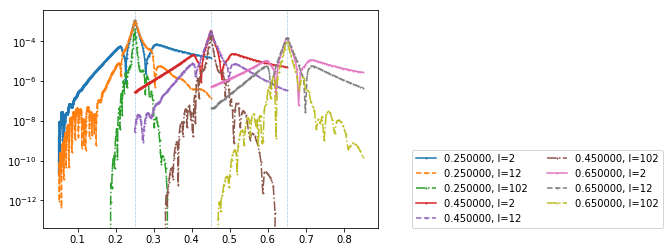

In [7]:
import fnmatch
#not very elegant, but seems to do the job: read in Cdd_ells

# this is the loop for low redshifts

z1s0 = np.arange(0.25,0.75,0.2)

print('low z1:',z1s0)

C_ells0 = []
z2s0 = []
z1_=[]
for z1 in z1s0:
    z2=[]
    C_ells=[]
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, 'C_ell_z1_%.3f_z2*_lmin2_lmax2000_nd0.dat'%z1):
            z1_+=[z1]
            C_ells +=[np.loadtxt(path+file,skiprows=1)[:,1]]
            
            try:
                z2+=[ast.literal_eval(file[18:25])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[18:24])]
                except:
                    z2+=[ast.literal_eval(file[18:23])]

        if fnmatch.fnmatch(file,'C_ell_z1_%.4f_z2*_lmin2_lmax2000_nd0.dat'%z1):
            z1_+=[z1]
            C_ells +=[np.loadtxt(path+file,skiprows=1)[:,1]]

            
            try:
                z2+=[ast.literal_eval(file[19:26])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[19:25])]
                except:
                    z2+=[ast.literal_eval(file[19:24])]
    print(len(z2))
    assert(len(z2)==len(np.unique(z2)))
    z2 = np.asarray(z2)
    ii = np.argsort(z2)
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,0]),marker='o',markersize='1',label='%f, l=%d'%(z1,ell[0]))
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,10]),marker='o',ls='--',markersize='1',label='%f, l=%d'%(z1,ell[10]))
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,100]),marker='o',ls='-.',markersize='1',label='%f, l=%d'%(z1,ell[100]))
    plt.axvline(z1,lw=0.5,ls=':')
    z2s0+=[z2[ii]]
    C_ells0+=[np.asarray(C_ells)[ii,:]]
plt.legend(ncol=2,loc=(1.1,0))
print(z1s0-np.unique(z1_))

low z1: [1.   1.95 2.9  3.85]
5331
291
136
83
[0. 0. 0. 0.]


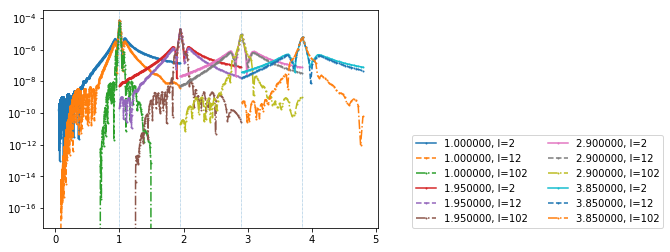

In [8]:
#not very elegant, but seems to do the job: read in Cdd_ells

# this is the loop for low redshifts

z1s1 = np.arange(1.,4.,0.95)
#z1s1 = np.insert(z1s1,0,np.arange(0.1,0.2,0.05))

print('low z1:',z1s1)

C_ells1 = []
z2s1 = []
z1_=[]
for z1 in z1s1:
    z2=[]
    C_ells=[]
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, 'C_ell_z1_%.3f_z2*_lmin2_lmax2000_nd0.dat'%z1):
            z1_+=[z1]
            C_ells +=[np.loadtxt(path+file,skiprows=1)[:,1]]
            try:
                z2+=[ast.literal_eval(file[18:25])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[18:24])]
                except:
                    z2+=[ast.literal_eval(file[18:23])]

        if fnmatch.fnmatch(file,'C_ell_z1_%.4f_z2*_lmin2_lmax2000_nd0.dat'%z1):
            z1_+=[z1]
            C_ells +=[np.loadtxt(path+file,skiprows=1)[:,1]]
            try:
                z2+=[ast.literal_eval(file[19:27])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[19:26])]
                except:
                    z2+=[ast.literal_eval(file[19:25])]
    print(len(z2))
    assert(len(z2)==len(np.unique(z2)))
    z2 = np.asarray(z2)
    ii = np.argsort(z2)
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,0]),marker='o',markersize='1',label='%f, l=%d'%(z1,ell[0]))
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,10]),marker='o',ls='--',markersize='1',label='%f, l=%d'%(z1,ell[10]))
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,100]),marker='o',ls='-.',markersize='1',label='%f, l=%d'%(z1,ell[100]))
    plt.axvline(z1,lw=0.5,ls=':')
    z2s1+=[z2[ii]]
    C_ells1+=[np.asarray(C_ells)[ii,:]]
plt.legend(ncol=2,loc=(1.1,0))
print(z1s1-np.unique(z1_))

high z1: [4.8  5.75 6.7  7.65 8.6 ]
58
43
34
27
23
[0. 0. 0. 0. 0.]


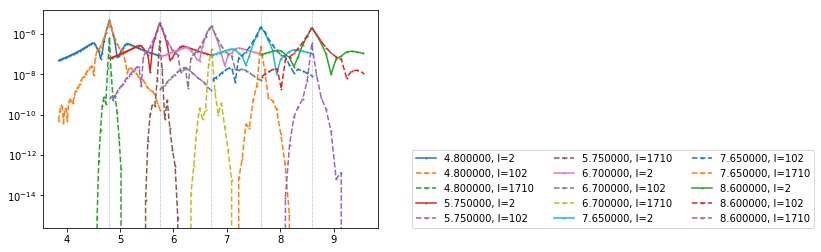

In [9]:
#high redshift z1s
#loop over these z1s
z1s2 = np.arange(4.8,9.0,0.95)

print('high z1:', z1s2)
ll_=0
C_ells2 = []
z2s2 = []
z1_=[]
plt.figure()
for z1 in z1s2:
    z2=[]
    C_ells=[]
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, 'C_ell_z1_%.3f_z2*.dat'%z1):
            z1_+=[z1]
            C_ells+=[np.loadtxt(path+file,skiprows=1)[:,1]]
            try:
                z2+=[ast.literal_eval(file[18:25])]
            except:
                try: 
                    z2+=[ast.literal_eval(file[18:24])]
                except:
                    z2+=[ast.literal_eval(file[18:23])]
                    
    assert(len(z2)==len(np.unique(z2)))
    print(len(z2))
    z2 = np.asarray(z2)
    ii = np.argsort(z2)
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,0]),marker='o',markersize='1',label='%f, l=%d'%(z1,ell[0]))
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,100]),ls='--',marker='o',markersize='1',label='%f, l=%d'%(z1,ell[100]))
    plt.semilogy(z2[ii],abs(np.asarray(C_ells)[ii,500]),ls='--',marker='o',markersize='1',label='%f, l=%d'%(z1,ell[500]))
    plt.axvline(z1,lw=0.5,ls=':')
    z2s2+=[z2[ii]]
    C_ells2+=[np.asarray(C_ells)[ii,:]]
plt.legend(ncol=3,loc=(1.1,0))
print(z1s2-np.unique(z1_))
z2s2=np.asarray(z2s2)

In [10]:
C_ells0 = np.asarray(C_ells0)
C_ells1 = np.asarray(C_ells1)
C_ells2 = np.asarray(C_ells2)


C_ells  = np.append(C_ells0,C_ells1)
C_ells  = np.append(C_ells,C_ells2)

print(C_ells0.shape)
print(C_ells1.shape)
print(C_ells2.shape)
print(np.asarray(C_ells).shape)

z2s0 = np.asarray(z2s0)
z2s1 = np.asarray(z2s1)
z2s2 = np.asarray(z2s2)
z2s  = np.append(z2s0,z2s1)
z2s  = np.append(z2s,z2s2)
z2s  = np.asarray(z2s)

print(z2s0.shape)
print(z2s1.shape)
print(z2s2.shape)
print(z2s.shape)



z1s = np.concatenate((z1s0,z1s1,z1s2))

print(z1s)

(3,)
(4,)
(5,)
(12,)
(3,)
(4,)
(5,)
(12,)
[0.25 0.45 0.65 1.   1.95 2.9  3.85 4.8  5.75 6.7  7.65 8.6 ]


In [11]:
def lensing_kernel(chi_max, chi_z):
    def kernel(z):
        chi = chi_z(z)
        return chi*(chi_max-chi)/chi_max*(1.+z)
    return kernel

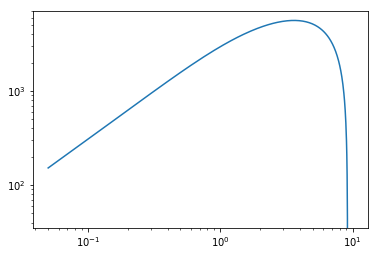

In [12]:
W = lensing_kernel(chi_cmb, chi_z)

z_= np.linspace(5e-2,10,200)
#plt.semilogy(z_,-W(z_))
plt.loglog(z_,W(z_))

[0.25 0.45 0.65 1.   1.95 2.9  3.85 4.8  5.75 6.7  7.65 8.6 ]


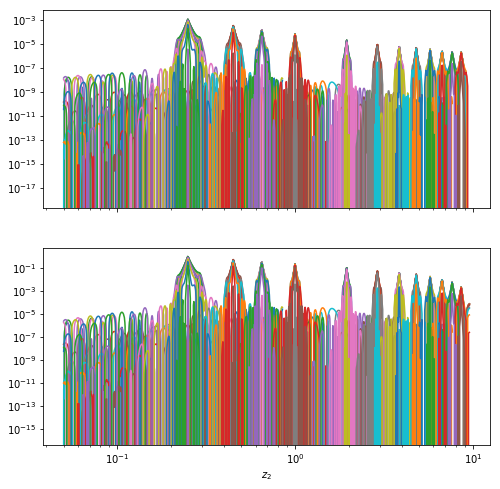

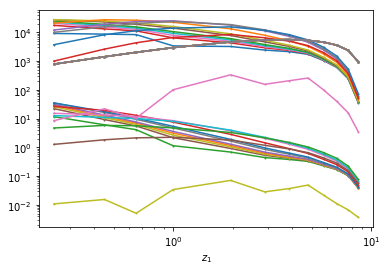

In [13]:
import scipy.integrate as inte
#chi(z1)
print(z1s)
chi1 = chi_z(z1s)
CLkk = []
#ell indices
index = [0,2,3,4,5,8,10,20,40,50,100,200,500]
f1, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))
f2, ax = plt.subplots()
for ll in index:
    res=[]
    for jj, z1 in enumerate(z1s):
        z2_ = z2s[jj]
        ii  = np.argsort(z2_)
        z2_ = np.asarray(z2_)
        z2_ = z2_[ii]
        C_ell = np.asarray(C_ells[jj])[:,ll]
        ax1.loglog(z2_,C_ell,ls='-')
        ax2.loglog(z2_,W(z2_)*C_ell,ls='-')
        res+=[inte.simps(W(z2_)*C_ell,chi_z(z2_))]
    CLkk+=[inte.simps(res*W(z1s),chi1)]
    ax.loglog(z1s,res*W(z1s),marker='o',markersize=1)
    ax.loglog(z1s,W(z1s),marker='o',markersize=1)
    ax.loglog(z1s,res,marker='o',markersize=1)

ax2.set_xlabel('$z_2$')   
ax.set_xlabel('$z_1$')
CLkk = np.asarray(CLkk)*prefac**2        
    

In [14]:
# import scipy.integrate as inte
# #chi(z1)
# print(z1s)
# chi1 = chi_z(z1s)
# CLkk = []
# #ell indices
# index = [0]#,2,3,4,5,8,10,20,40,50,100,200,500]
# f1, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,8))
# f2, ax = plt.subplots()
# for ll in index:
#     res=[]
#     for jj, z1 in enumerate(z1s):
#         z2_ = z2s[jj]
#         ii  = np.argsort(z2_)
#         z2_ = np.asarray(z2_)
#         z2_ = z2_[ii]
#         C_ell = np.asarray(C_ells[jj])[ii,ll]
#         ax1.loglog(z2_,C_ell,ls='-')
#         ax2.loglog(z2_[int(len(z2_)/2)],C_ell[int(len(z2_)/2)]/(W(z2_[int(len(z2_)/2)])*C_ell[int(len(z2_)/2)]),ls='-',marker='*')
#         #ax2.loglog(z2_[int(len(z2_)/2)],,ls='-',marker='*')
#         #ax2.loglog(z2_[int(len(z2_)/2)],,ls='-',marker='o')
#         #ax2.loglog(z2_[int(len(z2_)/2)],-W(z2_[int(len(z2_)/2)]),ls='-',marker='+')
#         res+=[inte.simps(W(z2_)*C_ell,chi_z(z2_))]
#     CLkk+=[inte.simps(res*W(z1s),chi1)]
#     ax.loglog(z1s,res*W(z1s),marker='o',markersize=1)
# ax2.set_xlabel('$z_2$')   
# ax.set_xlabel('$z_1$')
# CLkk = np.asarray(CLkk)*prefac**2        
    

In [15]:
L = ell[index]


In [16]:
cosmo_dict={'h': h,
'omega_b' : omega_b,
'omega_cdm': omega_cdm,
'A_s'    : A0,
'n_s'    : ns,
'k_pivot' : 0.05}
cosmo_dict['output']='lCl, tCl'
cosmo_dict['l_max_scalars']=2000
cosmo_dict['lensing']='yes'

In [17]:

cosmo.set(cosmo_dict)

True

In [18]:
cosmo.compute()

In [19]:
cllen= cosmo.lensed_cl(lmax=1000)

In [20]:
cosmo.empty()
closmo = Class()
cosmo_dict['l_switch_limber']=1
#cosmo_dict['perturb_sampling_stepsize']=0.01
closmo.set(cosmo_dict)
closmo.compute()
print(closmo.pars)

cllen_li= closmo.lensed_cl(lmax=1000)

{'h': 0.677, 'omega_b': 0.02247, 'omega_cdm': 0.11923, 'A_s': 2.10732e-09, 'n_s': 0.96824, 'k_pivot': 0.05, 'output': 'lCl, tCl', 'l_max_scalars': 2000, 'lensing': 'yes', 'l_switch_limber': 1}


In [21]:
ll = cllen['ell']
clpp = cllen['pp']

clpp_li = cllen_li['pp']

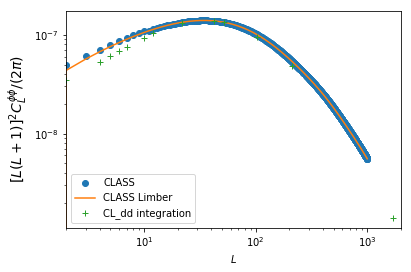

In [22]:
plt.figure()

plt.loglog(ll,(ll*(ll+1))**2*clpp/2./np.pi,ls='',marker='o',label='CLASS')
plt.loglog(ll,(ll*(ll+1))**2*clpp_li/2./np.pi,ls='-',label='CLASS Limber')
plt.loglog(L,4*CLkk/2./np.pi,ls='',marker='+',label='CL_dd integration')
#plt.loglog(L,4*(L*(L+1.))**2/L**4*CLkk/2./np.pi,ls='',marker='o',label='prefac correction')
plt.ylabel('$[L(L+1)]^2 C_L^{\phi\phi}/(2 \pi)$',fontsize=14)
plt.xlabel('$L$')
plt.xlim(2,2000)
plt.legend()
plt.savefig('../figures/Cls_from_Cldd.png',bbox_inches='tight')
plt.show()

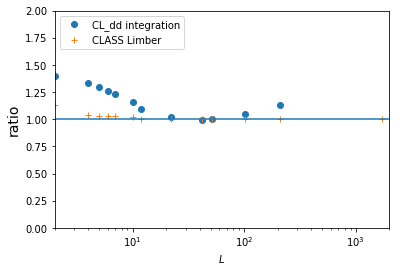

In [23]:
# ratio plot
if len(L)<len(clpp):
    clpp = np.interp(L,ll,clpp)
    clpp_li = np.interp(L,ll,clpp_li)
plt.figure()
plt.semilogx(L,1./4*(L*(L+1.))**2*clpp/CLkk,ls='',marker='o',label='CL_dd integration')
plt.semilogx(L,clpp/clpp_li,ls='',marker='+',label='CLASS Limber')
plt.ylabel('ratio',fontsize=14)
plt.xlabel('$L$')
plt.xlim(2,2000)
plt.ylim(0,2)
plt.axhline(1)
plt.legend()
plt.savefig('../figures/Cls_from_Cldd_ratio.png',bbox_inches='tight')
plt.show()